# 0. Import

In [1]:
!pip install yfinance


[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: C:\Users\Umair Sayed\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import random
from itertools import product

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Input, GRU

# 1. Load and Visualize Data

## 1.1 Load Data

In [5]:
# Download entire dataset for Google stock
google_stock = yf.Ticker('GOOGL').history(period='max')

display(google_stock.head())

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2004-08-19 00:00:00-04:00,2.496321,2.597672,2.395469,2.504808,893181924,0.0,0.0
2004-08-20 00:00:00-04:00,2.521534,2.722988,2.508803,2.703765,456686856,0.0,0.0
2004-08-23 00:00:00-04:00,2.764676,2.832825,2.722238,2.730976,365122512,0.0,0.0
2004-08-24 00:00:00-04:00,2.776908,2.785895,2.585440,2.617892,304946748,0.0,0.0
2004-08-25 00:00:00-04:00,2.620139,2.696027,2.593179,2.646101,183772044,0.0,0.0


In [6]:
google_stock.drop(columns=['Dividends', 'Stock Splits'], inplace=True)
display(google_stock.head())

,Open,High,Low,Close,Volume
Date,,,,,
2004-08-19 00:00:00-04:00,2.496321,2.597672,2.395469,2.504808,893181924
2004-08-20 00:00:00-04:00,2.521534,2.722988,2.508803,2.703765,456686856
2004-08-23 00:00:00-04:00,2.764676,2.832825,2.722238,2.730976,365122512
2004-08-24 00:00:00-04:00,2.776908,2.785895,2.585440,2.617892,304946748
2004-08-25 00:00:00-04:00,2.620139,2.696027,2.593179,2.646101,183772044


## 1.2 Visualize Data

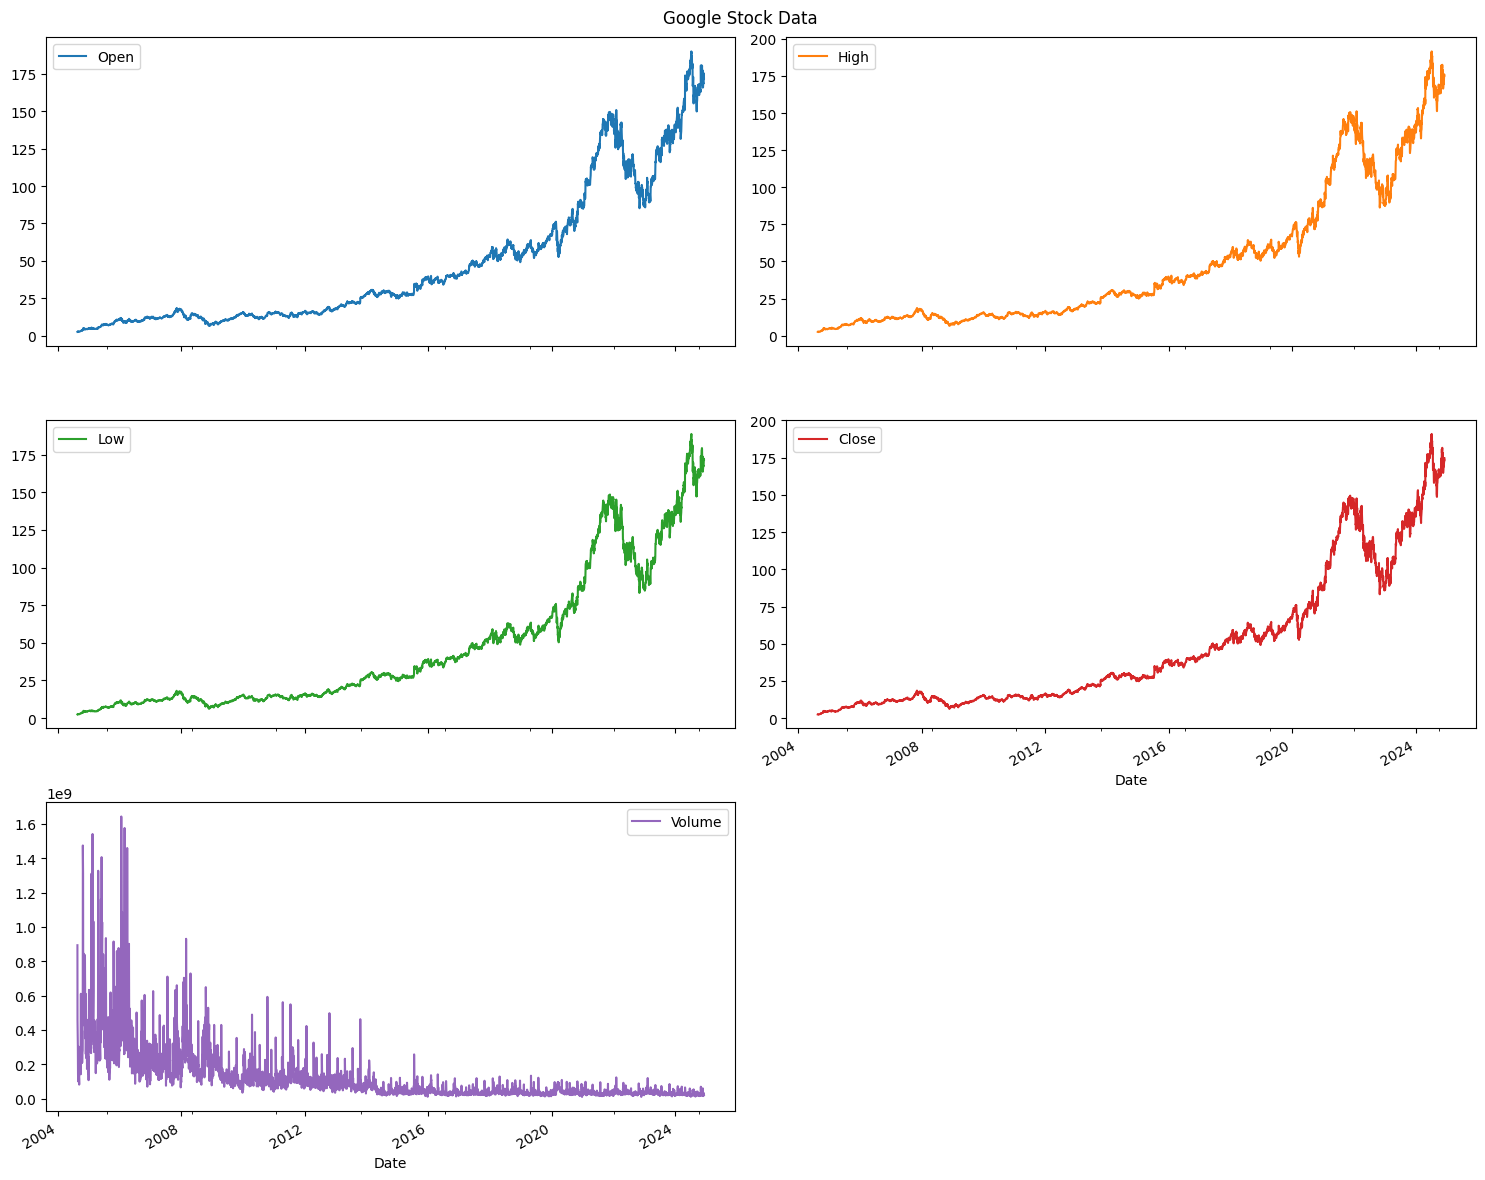

In [7]:
google_stock.plot(subplots=True, layout=(3, 2), figsize=(15, 12), title='Google Stock Data')
plt.tight_layout()
plt.show()

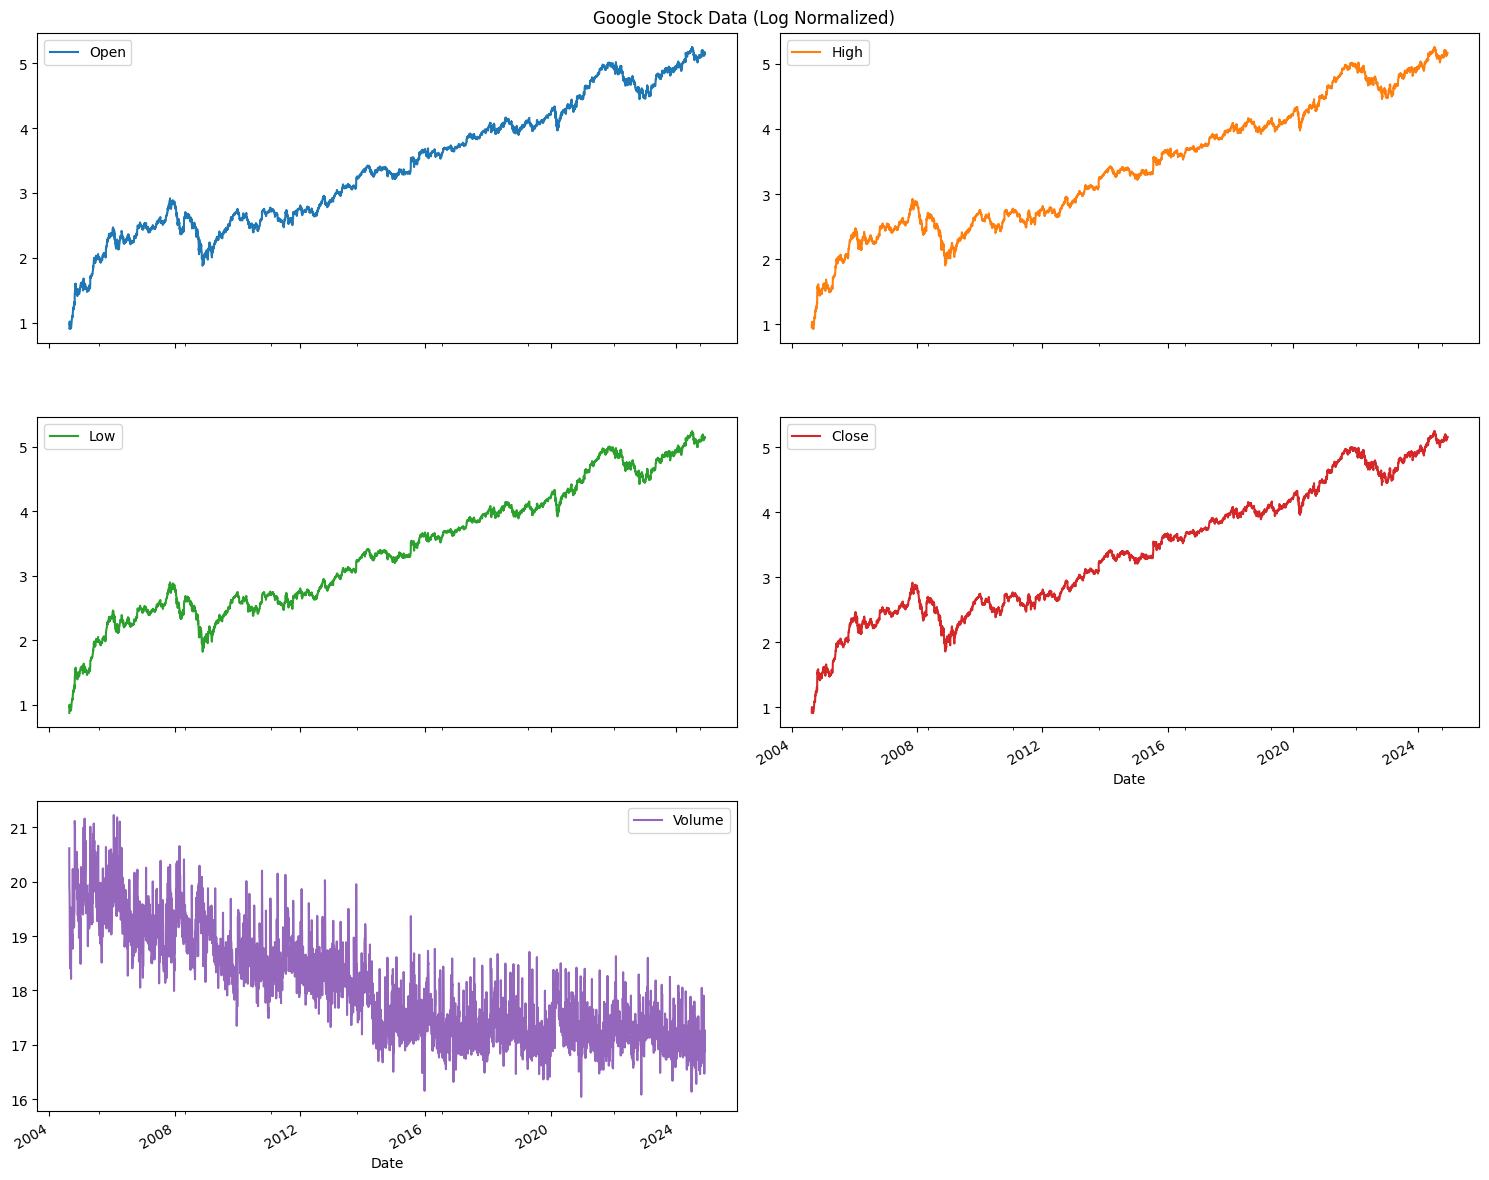

In [8]:
# Log normalize the data (excluding the 'Date' column)
google_stock_combined = google_stock.copy()
numeric_cols = google_stock_combined.select_dtypes(include=[np.number]).columns
google_stock_combined[numeric_cols] = np.log(google_stock_combined[numeric_cols])

# Plot the log normalized data
google_stock_combined.plot(subplots=True, layout=(3, 2), figsize=(15, 12), title='Google Stock Data (Log Normalized)')
plt.tight_layout()
plt.show()

In [9]:
google_stock_combined.describe()

,Open,High,Low,Close,Volume
count,5111.000000,5111.000000,5111.000000,5111.000000,5111.000000
mean,3.392531,3.403021,3.381572,3.392496,18.053940
std,0.991359,0.990517,0.992557,0.991627,0.961883
min,0.906685,0.932068,0.873579,0.914918,16.046814
25%,2.575937,2.584504,2.565043,2.575757,17.238143
50%,3.329213,3.335323,3.320168,3.327837,17.870456
75%,4.134380,4.145432,4.124802,4.136797,18.753406
max,5.247328,5.254866,5.240580,5.251889,21.219804


# 2. Split the Data

In [ ]:
google_stock_combined['Year'] = google_stock_combined.index.year

train_years = google_stock_combined['Year'] <= 2022
val_years = (google_stock_combined['Year'] > 2022) & (google_stock_combined['Year'] <= 2023) 
test_years = google_stock_combined['Year'] == 2024

train_data = google_stock_combined[train_years].copy()
val_data = google_stock_combined[val_years].copy()
test_data = google_stock_combined[test_years].copy()

train_data = train_data.drop(columns=['Year'])
val_data = val_data.drop(columns=['Year'])
test_data = test_data.drop(columns=['Year'])

print("Training Set Shape:", train_data.shape)
print("Validation Set Shape:", val_data.shape)
print("Test Set Shape:", test_data.shape)

Training Set Shape: (4625, 5)
Validation Set Shape: (250, 5)
Test Set Shape: (236, 5)


# 3. Common Functions

In [ ]:
def save_metrics(model_name, val_metrics):
    metrics = {
        "Model": model_name,
        "Validation MSE": val_metrics[1],  
        "Validation RMSE": val_metrics[2],
        "Validation MDA": val_metrics[3]
    }
    return metrics


def plot_predictions(y_true, y_pred, title="True vs Predicted"):
    
    if len(y_true.shape) > 1:  
        y_true = y_true[:, 0]  
    if len(y_pred.shape) > 1:  
        y_pred = y_pred[:, 0]  
    # Check for consistent length
    min_len = min(len(y_true), len(y_pred))
    y_true = y_true[:min_len]
    y_pred = y_pred[:min_len]

    plt.figure(figsize=(10, 6))
    plt.plot(range(len(y_true)), y_true, label="True Values", color="blue")
    plt.plot(range(len(y_pred)), y_pred, label="Predicted Values", color="orange")
    plt.title(title)
    plt.xlabel("Time Steps")
    plt.ylabel("Stock Close Price")
    plt.legend()
    plt.show()

In [13]:
# RMSE metric
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

# MDA metric
def mda(y_true, y_pred):
    d = K.equal(K.sign(y_true[1:] - y_true[:-1]), K.sign(y_pred[1:] - y_pred[:-1]))
    return K.mean(K.cast(d, K.floatx()))

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

### Sliding Window Sequence Creation

In [ ]:
def create_sequences(data, features, target_col, N, M):
    """
    Create sliding window sequences for RNN models.
    
    Parameters:
        data (pd.DataFrame): The full dataset.
        features (list): List of feature column names for input sequences.
        target_col (str): The target column name to predict.
        N (int): Number of historical days for input sequences.
        M (int): Number of days to predict.
    """
    X, y = [], []
    for i in range(len(data) - N - M + 1):
        # Create input sequence from features
        X.append(data[features].iloc[i:i + N].values)
        # Create target sequence from target column
        y.append(data[target_col].iloc[i + N:i + N + M].values)
    return np.array(X), np.array(y)

In [ ]:
N = 50 # Number of historical days to look at
M = 1  # Number of days to predict
features = ['Open', 'High', 'Low', 'Close', 'Volume']
target_col = 'Close'

# Create sequences for training, validation, and testing
X_train, y_train = create_sequences(train_data, features, target_col, N, M)
X_val, y_val = create_sequences(val_data, features, target_col, N, M)
X_test, y_test = create_sequences(test_data, features, target_col, N, M)

print("Training Data Shape (X, y):", X_train.shape, y_train.shape)
print("Validation Data Shape (X, y):", X_val.shape, y_val.shape)
print("Test Data Shape (X, y):", X_test.shape, y_test.shape)

Training Data Shape (X, y): (4575, 50, 5) (4575, 1)
Validation Data Shape (X, y): (200, 50, 5) (200, 1)
Test Data Shape (X, y): (186, 50, 5) (186, 1)


# 4. Model Selection

## 4.1 Simple RNN

In [ ]:
rnn_baseline = keras.models.Sequential()
rnn_baseline.add(SimpleRNN(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
rnn_baseline.add(Dropout(0.2))
rnn_baseline.add(Dense(1))

rnn_baseline.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                    loss='mse', 
                    metrics=['mse', rmse, mda])

rnn_baseline.summary()

C:\Users\Umair Sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_113"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_4 (SimpleRNN)        │ (None, 50)             │         2,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_113 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_113 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,851 (11.14 KB)

 Trainable params: 2,851 (11.14 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = rnn_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.0652 - mda: 0.5424 - mse: 8.0652 - rmse: 2.5749 - val_loss: 0.2548 - val_mda: 0.4595 - val_mse: 0.2548 - val_rmse: 0.5086
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 1.0024 - mda: 0.7134 - mse: 1.0024 - rmse: 0.9921 - val_loss: 0.1137 - val_mda: 0.5122 - val_mse: 0.1137 - val_rmse: 0.3399
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.5898 - mda: 0.7684 - mse: 0.5898 - rmse: 0.7584 - val_loss: 0.0101 - val_mda: 0.4918 - val_mse: 0.0101 - val_rmse: 0.1043
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.3238 - mda: 0.8063 - mse: 0.3238 - rmse: 0.5642 - val_loss: 0.0065 - val_mda: 0.5813 - val_mse: 0.0065 - val_rmse: 0.0826
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2353 - mda: 0.8333 - mse: 0.2353 - rmse: 0.4804 - val_loss: 0.0052 - val_mda: 0.5813 - val_mse: 0.0052 - val_rmse: 0.0741
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.2093 - mda: 0.8388

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0044 - mda: 0.5731 - mse: 0.0044 - rmse: 0.0669 
{'Model': 'Simple RNN', 'Validation MSE': 0.004526604898273945, 'Validation RMSE': 0.06997264176607132, 'Validation MDA': 0.5720868706703186}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


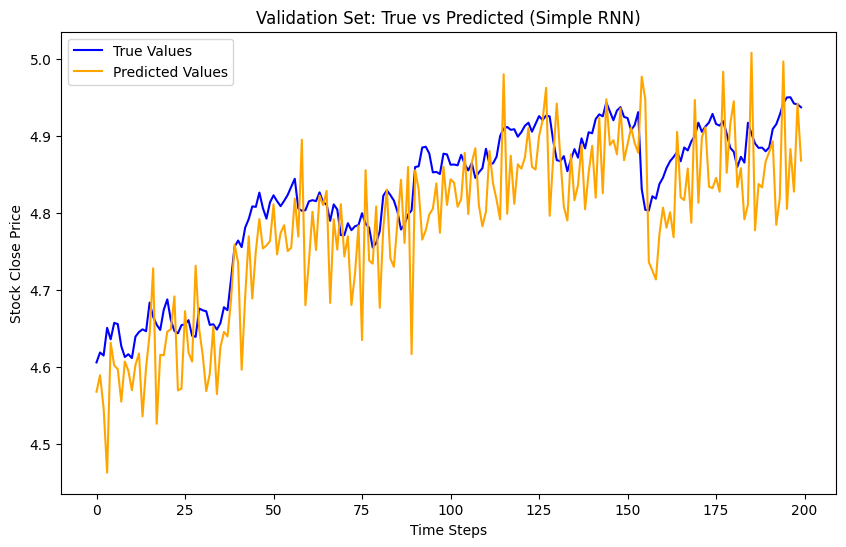

In [ ]:
val_metrics = rnn_baseline.evaluate(X_val, y_val, verbose=1)

simple_rnn_metrics = save_metrics("Simple RNN", val_metrics)
print(simple_rnn_metrics)

y_pred_val = rnn_baseline.predict(X_val)

plot_predictions(y_val, y_pred_val, title="Validation Set: True vs Predicted (Simple RNN)")

## 4.2 LSTM - Baseline

In [70]:
lstm_baseline = keras.models.Sequential()
lstm_baseline.add(keras.layers.LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_baseline.add(keras.layers.Dropout(0.2))
lstm_baseline.add(keras.layers.Dense(1))

lstm_baseline.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), 
                      loss='mse', 
                      metrics=['mse', rmse, mda])

lstm_baseline.summary()

Model: "sequential_109"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 50)             │        11,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_109 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,251 (43.95 KB)

 Trainable params: 11,251 (43.95 KB)

 Non-trainable params: 0 (0.00 B)

In [71]:
history_lstm = lstm_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 2.4896 - mda: 0.6334 - mse: 2.4896 - rmse: 1.3312 - val_loss: 0.0044 - val_mda: 0.3976 - val_mse: 0.0044 - val_rmse: 0.0587
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.3217 - mda: 0.8243 - mse: 0.3217 - rmse: 0.5618 - val_loss: 0.4461 - val_mda: 0.4753 - val_mse: 0.4461 - val_rmse: 0.6652
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.2676 - mda: 0.8349 - mse: 0.2676 - rmse: 0.5118 - val_loss: 0.1313 - val_mda: 0.4273 - val_mse: 0.1313 - val_rmse: 0.3614
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.2053 - mda: 0.8414 - mse: 0.2053 - rmse: 0.4486 - val_loss: 0.0538 - val_mda: 0.4226 - val_mse: 0.0538 - val_rmse: 0.2324
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1819 - mda: 0.8426 - mse: 0.1819 - rmse: 0.4214 - val_loss: 0.0434 - val_mda: 0.4022 - val_mse: 0.0434 - val_rmse: 0.2096
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.1800 - mda: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0029 - mda: 0.3523 - mse: 0.0029 - rmse: 0.0528 
{'Model': 'Simple RNN', 'Validation MSE': 0.0022785463370382786, 'Validation RMSE': 0.0461735725402832, 'Validation MDA': 0.5635286569595337}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


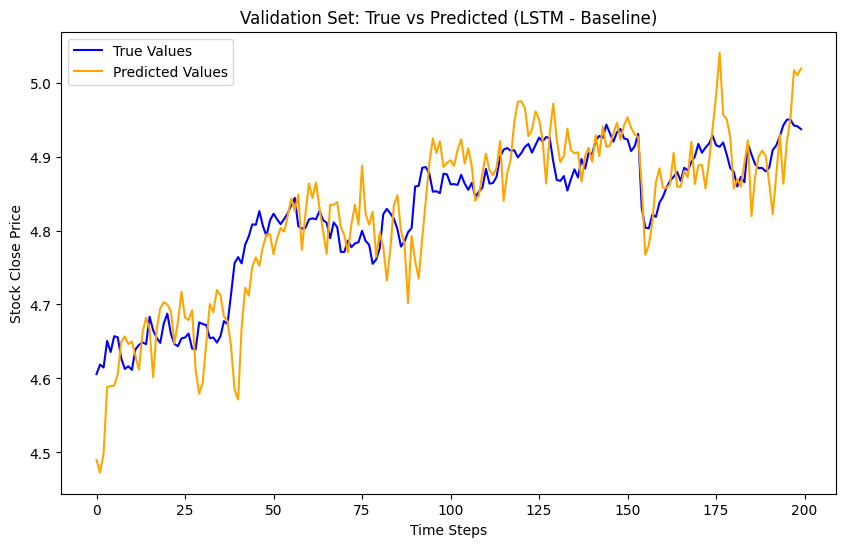

In [72]:
val_metrics_lstm  = lstm_baseline.evaluate(X_val, y_val, verbose=1)

lstm_baseline_metrics = save_metrics("LSTM - Baseline", val_metrics_lstm)
print(simple_rnn_metrics)

y_pred_val = lstm_baseline.predict(X_val)
plot_predictions(y_val, y_pred_val, title="Validation Set: True vs Predicted (LSTM - Baseline)")

## 4.3 GRU - Baseline

In [89]:
gru_baseline = keras.models.Sequential()

gru_baseline.add(GRU(units=50, 
                     activation='relu', 
                     input_shape=(X_train.shape[1], X_train.shape[2])))

gru_baseline.add(Dropout(0.2))
gru_baseline.add(Dense(1))


gru_baseline.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    metrics=['mse', rmse, mda]
)

gru_baseline.summary()

C:\Users\Umair Sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_114"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_107 (GRU)                   │ (None, 50)             │         8,550 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_114 (Dropout)           │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_114 (Dense)               │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,601 (33.60 KB)

 Trainable params: 8,601 (33.60 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_history = gru_baseline.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    verbose=1,
    callbacks=[early_stopping]
)

Epoch 1/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step - loss: 2.9514 - mda: 0.6689 - mse: 2.9514 - rmse: 1.4599 - val_loss: 0.2419 - val_mda: 0.5379 - val_mse: 0.2419 - val_rmse: 0.4968
Epoch 2/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3935 - mda: 0.8004 - mse: 0.3935 - rmse: 0.6174 - val_loss: 0.1472 - val_mda: 0.5214 - val_mse: 0.1472 - val_rmse: 0.3872
Epoch 3/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3028 - mda: 0.8094 - mse: 0.3028 - rmse: 0.5451 - val_loss: 0.0593 - val_mda: 0.5076 - val_mse: 0.0593 - val_rmse: 0.2450
Epoch 4/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2611 - mda: 0.8226 - mse: 0.2611 - rmse: 0.5079 - val_loss: 0.0077 - val_mda: 0.4918 - val_mse: 0.0077 - val_rmse: 0.0860
Epoch 5/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2662 - mda: 0.8281 - mse: 0.2662 - rmse: 0.5092 - val_loss: 0.0036 - val_mda: 0.5352 - val_mse: 0.0036 - val_rmse: 0.0561
Epoch 6/50
143/143 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.2280 - mda: 

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0014 - mda: 0.4994 - mse: 0.0014 - rmse: 0.0356 
{'Model': 'GRU - Baseline', 'Validation MSE': 0.0011502825655043125, 'Validation RMSE': 0.030120855197310448, 'Validation MDA': 0.5260039567947388}
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


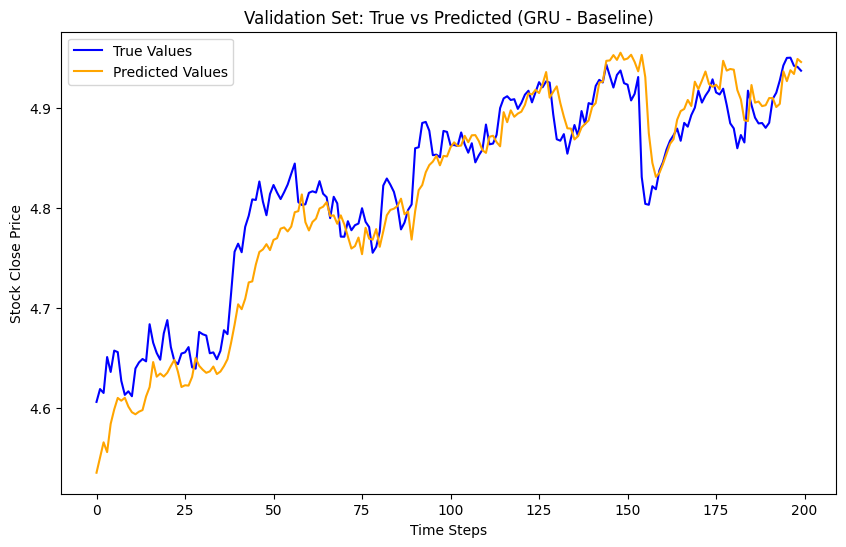

In [91]:
gru_val_metrics = gru_baseline.evaluate(X_val, y_val, verbose=1)

gru_baseline_metrics = save_metrics("GRU - Baseline", gru_val_metrics)
print(gru_baseline_metrics)

y_pred_val = gru_baseline.predict(X_val)
plot_predictions(y_val, y_pred_val, title="Validation Set: True vs Predicted (GRU - Baseline)")

# 5. Compare models

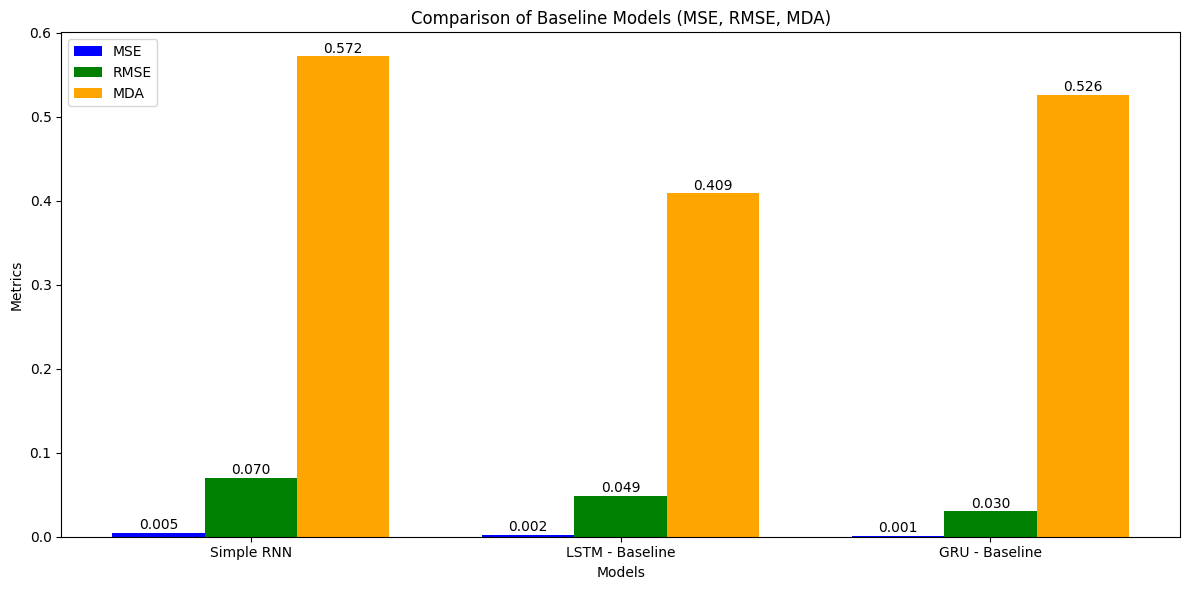

In [ ]:
models_metrics = [simple_rnn_metrics, lstm_baseline_metrics, gru_baseline_metrics]

models = [metrics["Model"] for metrics in models_metrics]
mse_values = [metrics["Validation MSE"] for metrics in models_metrics]
rmse_values = [metrics["Validation RMSE"] for metrics in models_metrics]
mda_values = [metrics["Validation MDA"] for metrics in models_metrics]

x = np.arange(len(models))
bar_width = 0.25

plt.figure(figsize=(12, 6))

# Plot MSE
plt.bar(x - bar_width, mse_values, bar_width, label="MSE", color="blue")
for i, val in enumerate(mse_values):
    plt.text(x[i] - bar_width, val + 0.001, f"{val:.3f}", ha="center", va="bottom")

# Plot RMSE
plt.bar(x, rmse_values, bar_width, label="RMSE", color="green")
for i, val in enumerate(rmse_values):
    plt.text(x[i], val + 0.001, f"{val:.3f}", ha="center", va="bottom")

# Plot MDA
plt.bar(x + bar_width, mda_values, bar_width, label="MDA", color="orange")
for i, val in enumerate(mda_values):
    plt.text(x[i] + bar_width, val + 0.001, f"{val:.3f}", ha="center", va="bottom")

plt.xlabel("Models")
plt.ylabel("Metrics")
plt.title("Comparison of Baseline Models (MSE, RMSE, MDA)")
plt.xticks(x, models)
plt.legend()
plt.tight_layout()
plt.show()

# 6. Hyper-Parameter tuning the Best Model

In [ ]:
def create_gru_model(units=50, dropout_rate=0.2, learning_rate=0.001):
    model = keras.models.Sequential([
        GRU(units=units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(dropout_rate),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  loss='mse',
                  metrics=['mse', rmse, mda])
    return model

param_grid = {
    'units': [50, 100, 150],
    'dropout_rate': [0.2, 0.3, 0.4],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [16, 32, 64],
    'epochs': [20, 50]
}

param_combinations = list(product(*param_grid.values()))

random.seed(42)
sampled_combinations = random.sample(param_combinations, 20)

best_params = None
best_score = float('inf')

for params in sampled_combinations:
    param_dict = dict(zip(param_grid.keys(), params))
    print(f"Testing parameters: {param_dict}")

    model = create_gru_model(units=param_dict['units'],
                             dropout_rate=param_dict['dropout_rate'],
                             learning_rate=param_dict['learning_rate'])
    
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=param_dict['epochs'],
                        batch_size=param_dict['batch_size'],
                        verbose=0)
    
    val_loss = model.evaluate(X_val, y_val, verbose=0)[0]
    print(f"Validation loss: {val_loss:.4f}")
    
    if val_loss < best_score:
        best_score = val_loss
        best_params = param_dict

print("Best parameters:", best_params)
print("Best validation loss:", best_score)

Testing parameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 64, 'epochs': 20}


C:\Users\Umair Sayed\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Validation loss: 0.0028
Testing parameters: {'units': 50, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 16, 'epochs': 20}
Validation loss: 0.0016
Testing parameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 20}
Validation loss: 0.5769
Testing parameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 20}
Validation loss: 0.0013
Testing parameters: {'units': 100, 'dropout_rate': 0.2, 'learning_rate': 0.001, 'batch_size': 32, 'epochs': 50}
Validation loss: 0.0048
Testing parameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 64, 'epochs': 50}
Validation loss: 0.4286
Testing parameters: {'units': 50, 'dropout_rate': 0.3, 'learning_rate': 0.01, 'batch_size': 32, 'epochs': 20}
Validation loss: 0.0255
Testing parameters: {'units': 150, 'dropout_rate': 0.3, 'learning_rate': 0.1, 'batch_size': 16, 'epochs': 50}
Validation loss: nan
Testing parameters: {'units': 50, 'drop

# 7. Best Model with Best Params on Test Data

In [ ]:
best_units = best_params['units']
best_dropout_rate = best_params['dropout_rate']
best_learning_rate = best_params['learning_rate']
best_batch_size = best_params['batch_size']
best_epochs = best_params['epochs']

final_model = keras.models.Sequential([
    GRU(units=best_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_dropout_rate),
    Dense(1)
])
final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_learning_rate),
                    loss='mse',
                    metrics=['mse', rmse, mda])


X_combined = np.concatenate((X_train, X_val), axis=0)
y_combined = np.concatenate((y_train, y_val), axis=0)

history = final_model.fit(X_combined, y_combined,
                          epochs=best_epochs,
                          batch_size=best_batch_size,
                          verbose=1,
                          callbacks=[early_stopping])

Epoch 1/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 3.2712 - mda: 0.6088 - mse: 3.2712 - rmse: 1.5750
Epoch 2/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.3436 - mda: 0.8077 - mse: 0.3436 - rmse: 0.5823
Epoch 3/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.2261 - mda: 0.8400 - mse: 0.2261 - rmse: 0.4742
Epoch 4/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1743 - mda: 0.8732 - mse: 0.1743 - rmse: 0.4156
Epoch 5/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1362 - mda: 0.8813 - mse: 0.1362 - rmse: 0.3671
Epoch 6/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1125 - mda: 0.8797 - mse: 0.1125 - rmse: 0.3342
Epoch 7/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.1115 - mda: 0.8789 - mse: 0.1115 - rmse: 0.3321
Epoch 8/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.1065 - mda: 0.8833 - mse: 0.1065 - rmse: 0.3245
Epoch 9/50
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.1040 - mda: 0.8997 - mse: 0.1040 - rmse: 0.3208
Epoch 10/50
75/75 ━

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.1061e-04 - mda: 0.4846 - mse: 7.1061e-04 - rmse: 0.0256 
{'Model': 'Best Model - GRU', 'Validation MSE': 0.0007724349852651358, 'Validation RMSE': 0.026678843423724174, 'Validation MDA': 0.4887993037700653}
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


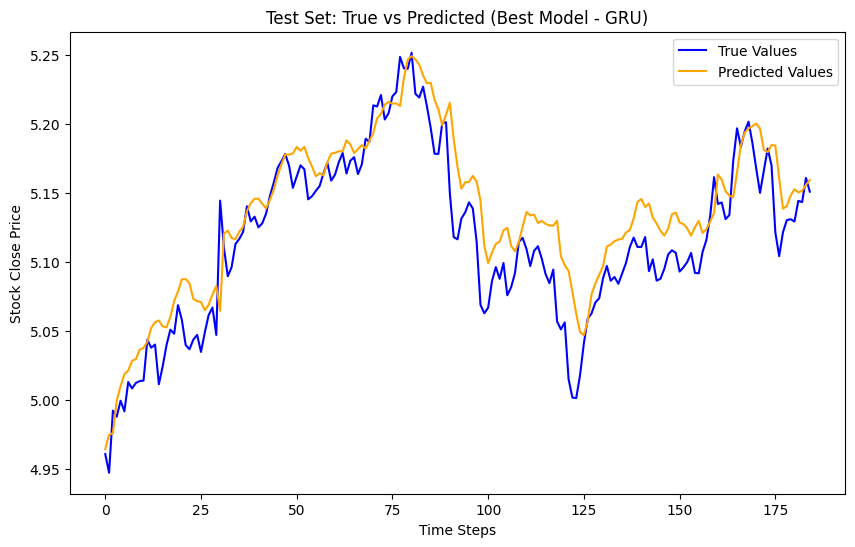

In [ ]:
final_test_metrics = final_model.evaluate(X_test, y_test, verbose=1)

final_metrics = save_metrics("Best Model - GRU", final_test_metrics)
print(final_metrics)

# Predict on the test set
y_pred_test = final_model.predict(X_test)

plot_predictions(y_test, y_pred_test, title="Test Set: True vs Predicted (Best Model - GRU)")